<a href="https://colab.research.google.com/github/bndxn/dissertation/blob/main/Model_32_ConvLSTM_vs_CNN%2C_1hr_inputs_with_pv%2C_diff_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install suncalc --quiet

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from google.colab import drive
from suncalc import get_position, get_times
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn import utils

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/dissertation/data_pipeline/sat_pipeline'

train_sat_images = np.load('{}/train_sat_images_reduced_smaller.npy'.format(PATH))
train_sat_times = np.load('{}/train_sat_times_reduced.npy'.format(PATH))

test_sat_images = np.load('{}/test_sat_images_reduced_smaller.npy'.format(PATH))
test_sat_times = np.load('{}/test_sat_times_reduced.npy'.format(PATH))

test_pv = np.load('{}/test_pv_lined_with_reduced_sat_normalised.npy'.format(PATH))
train_pv = np.load('{}/train_pv_lined_with_reduced_sat_normalised.npy'.format(PATH))

# Code to make blocks

In [ ]:
def get_list_of_days(list_of_timestamps):

  list_of_days = []

  for i in list_of_timestamps:
    list_of_days.append(pd.Timestamp(i).date())

  return list(dict.fromkeys(list_of_days))

def get_blocks_of_timestamps_for_one_day(date, list_of_timestamps, block_length):

  timestamps_in_day = []

  for i in list_of_timestamps:
    if pd.Timestamp(i).date() == date:
      timestamps_in_day.append(i)

  blocks_in_day = (len(timestamps_in_day) // (block_length)) 

  block_list = []

  for i in range(blocks_in_day):
    block = timestamps_in_day[(i*block_length):(i+1)*block_length] # We make a slice from the timestamps_in_day list
    block_list.append(block)

  return np.asarray(block_list)

def get_full_block_list(list_of_timestamps, block_length):

  list_of_days = get_list_of_days(list_of_timestamps)

  full_block_list = []

  for day in list_of_days:
    block_list_for_day = get_blocks_of_timestamps_for_one_day(day, list_of_timestamps, block_length)
    
    if block_list_for_day.shape[0] != 0: # some days there are no PV readings, exclude those
      full_block_list.append(block_list_for_day)

  full_block_list = np.concatenate(full_block_list)

  return full_block_list

def make_altitude_array(pv_timestamps):

  lat = 50.73
  lon = -4.19

  n_blocks = pv_timestamps.shape[0]
  slices_per_block = pv_timestamps.shape[1]

  altitudes = np.zeros(shape=(n_blocks, slices_per_block))

  for i in range(n_blocks):
    for j in range(slices_per_block):
      altitudes[i,j] = get_position(pd.Timestamp(pv_timestamps[i,j]), lon, lat).get('altitude')

  #print('Size :', altitudes.shape)  
  return altitudes

In [ ]:
# This function creates sat and pv blocks

def get_sat_and_pv_blocks(sat_times_list, sat_images_list, pv_list, n_sat_images, n_pv_targets):

  full_block_list = get_full_block_list(sat_times_list, n_sat_images + n_pv_targets)

  length = full_block_list.shape[0]

  sat_images_array = np.zeros(shape=(length, n_sat_images, 64, 64))
  pv_inputs_array = np.zeros(shape=(length, n_sat_images))
  pv_targets_array = np.zeros(shape=(length, n_pv_targets))


  sat_timestamps = np.zeros(shape=(length, n_sat_images))
  pv_timestamps = np.zeros(shape=(length, n_pv_targets))


  for i in range(full_block_list.shape[0]):
    for j in range(full_block_list.shape[1]):

      # For the first 12 values, get the satellite images, which we find using the index

      if j < n_sat_images:
        timestamp = full_block_list[i,j]
        index = np.where(sat_times_list == timestamp)[0][0]
        sat_images_array[i,j] = sat_images_list[index]
        sat_timestamps[i,j] = timestamp
        pv_inputs_array[i,j] = pv_list[index]

      # If j is larger than 12, then get the pv readings, again using the index
      
      else:
        timestamp = full_block_list[i,j]
        index = np.where(sat_times_list == timestamp)[0][0]
        pv_targets_array[i,(j-n_sat_images)] = pv_list[index]
        pv_timestamps[i,(j-n_sat_images)] = timestamp


  # Now create the altitudes
  pv_altitudes = make_altitude_array(pv_timestamps)


  print('Satellite and PV blocks generated.')
  print('\nSat images array:', sat_images_array.shape, ', PV targets array:', pv_targets_array.shape)
  print('Timestamps, sat', sat_timestamps.shape, ' , pv', pv_timestamps.shape)
  print('PV inputs', pv_inputs_array.shape)
  print('Altitudes for PV timestamps', pv_altitudes.shape)

  return sat_images_array, pv_inputs_array, pv_altitudes, pv_targets_array, sat_timestamps, pv_timestamps


# Input function

In [ ]:
def dataloader(n_preds, n_back, train_sat_images, train_sat_times, test_sat_images, test_sat_times, train_pv, test_pv):

  train_sat_images_blocks, train_pv_inputs, train_pv_altitudes, train_pv_targets,  train_sat_timestamps, train_pv_timestamps = get_sat_and_pv_blocks(sat_times_list=train_sat_times, 
                                                                                                              sat_images_list=train_sat_images, 
                                                                                                              pv_list=train_pv, 
                                                                                                              n_sat_images=n_back,
                                                                                                              n_pv_targets=n_preds)

  test_sat_images_blocks, test_pv_inputs, test_pv_altitudes, test_pv_targets, test_sat_timestamps, test_pv_timestamps = get_sat_and_pv_blocks(sat_times_list=test_sat_times, 
                                                                                                          sat_images_list=test_sat_images, 
                                                                                                          pv_list=test_pv, 
                                                                                                          n_sat_images=n_back, 
                                                                                                          n_pv_targets=n_preds)

  combined_timestamps = np.append(test_pv_timestamps, train_pv_timestamps)
  timestep_max = combined_timestamps.max()

  del combined_timestamps

  train_pv_timestamps_normalised = np.divide(train_pv_timestamps, timestep_max)
  test_pv_timestamps_normalised = np.divide(test_pv_timestamps, timestep_max)

  x_train_sat, x_train_alt, x_train_timestamps, x_train_pv_inputs, y_train = utils.shuffle(train_sat_images_blocks,  
                                                                                          train_pv_altitudes, 
                                                                                          train_pv_timestamps_normalised, 
                                                                                          train_pv_inputs, 
                                                                                          train_pv_targets)

  x_test_sat, x_test_alt, x_test_timestamps, x_test_pv_inputs, y_test = utils.shuffle(test_sat_images_blocks, 
                                                                                      test_pv_altitudes, 
                                                                                      test_pv_timestamps_normalised, 
                                                                                      test_pv_inputs, 
                                                                                      test_pv_targets)

  x_train_sat = np.expand_dims(x_train_sat, axis=-1)
  x_test_sat = np.expand_dims(x_test_sat, axis=-1)

  x_train_alt = np.expand_dims(x_train_alt, axis=-1)
  x_test_alt = np.expand_dims(x_test_alt, axis=-1)

  x_train_timestamps = np.expand_dims(x_train_timestamps, axis=-1)
  x_test_timestamps = np.expand_dims(x_test_timestamps, axis=-1)

  x_train_pv_inputs = np.expand_dims(x_train_pv_inputs, axis=-1)
  x_test_pv_inputs = np.expand_dims(x_test_pv_inputs, axis=-1) 

  del train_sat_images_blocks, test_sat_images_blocks
  del train_sat_images, test_sat_images

  return x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test


# Models

In [ ]:
def convlstm_model(n_timesteps, x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test):

  inp1 = layers.Input(shape=(x_train_sat.shape[1:]), name='x_sat')
  inp2 = layers.Input(shape=(x_train_pv_inputs.shape[1:]), name='x_pv_input')

  dropout_rate = 0.5

  x = layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), recurrent_dropout=dropout_rate, return_sequences=True, activation="relu")(inp1)
  x = layers.MaxPooling3D(pool_size=(3,3,3))(x)

  x = layers.ConvLSTM2D(filters=32, kernel_size=(3,3), recurrent_dropout=dropout_rate, return_sequences=True, activation="relu") (x)
  x = layers.MaxPooling3D(pool_size=(3,3,3))(x)

  x = layers.ConvLSTM2D(filters=32, kernel_size=(3,3), recurrent_dropout=dropout_rate, return_sequences=False, activation="relu") (x)
  x = layers.MaxPooling2D(pool_size=(3,3))(x)

  x = layers.Flatten()(x)

  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(128, activation="relu")(x)

  y = layers.LSTM(48)(inp2)

  z = layers.concatenate([x,y])
  z = layers.Dense(128)(z)
  z = layers.Dropout(0.5)(z)
  z = layers.Dense(n_timesteps, activation="linear")(z)

  model = keras.models.Model(inputs=[inp1, inp2], outputs=z)
  model.compile(
      loss='mse', optimizer=keras.optimizers.Adam(),
  )

  early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

  # Training hyperparameters
  epochs = 10
  batch_size = 5

  # Fit the model to the training data.
  history = model.fit(
      {"x_sat" : x_train_sat, "x_pv_input" : x_train_pv_inputs},
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.1, 
      callbacks=[early_stopping, reduce_lr],
  )

  plt.figure(figsize=(10,6))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], '.', label='validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('ConvLSTN with pv_inputs, {} minutes ahead, MSE'.format(5*n_timesteps))
  plt.legend();

  model_results = model.evaluate(
    x={"x_sat": x_test_sat, "x_pv_input": x_test_pv_inputs},
    y=y_test, 
    return_dict=True)
    
  return model_results

In [ ]:
def cnn_model(n_timesteps, x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test):

  inp1 = layers.Input(shape=(x_train_sat.shape[1:]), name='x_sat')
  inp2 = layers.Input(shape=(x_train_pv_inputs.shape[1:]), name='x_pv_input')

  dropout_rate = 0.5

  x = layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding="same", activation="relu", input_shape=x_train_sat.shape[1:])(inp1)
  x = layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding="same", activation="relu")(x)
  x = layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding="same", activation="relu")(x)

  x = layers.Flatten()(x)

  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(128, activation="relu")(x)

  y = layers.Dense(48)(inp2)
  y = layers.Flatten()(y)


  z = layers.concatenate([x,y])
  z = layers.Dense(128)(z)
  z = layers.Dropout(0.5)(z)
  z = layers.Dense(n_timesteps, activation="linear")(z)

  model = keras.models.Model(inputs=[inp1, inp2], outputs=z)
  model.compile(
      loss='mse', optimizer=keras.optimizers.Adam(),
  )

  early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

  # Training hyperparameters
  epochs = 10
  batch_size = 5

  # Fit the model to the training data.
  history = model.fit(
      {"x_sat" : x_train_sat, "x_pv_input" : x_train_pv_inputs},
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.1, 
      callbacks=[early_stopping, reduce_lr],
  )

  plt.figure(figsize=(10,6))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], '.', label='validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('CNN with pv_inputs, {} minutes ahead, MSE'.format(5*n_timesteps))
  plt.legend();

  model_results = model.evaluate(
    x={"x_sat": x_test_sat, "x_pv_input": x_test_pv_inputs},
    y=y_test, 
    return_dict=True)
    
  return model_results

# Comparison for 1hr forward, 1hr input, no padding, no mask




In [ ]:
x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test = dataloader(12, 12, train_sat_images, train_sat_times, test_sat_images, test_sat_times, train_pv, test_pv)

Satellite and PV blocks generated.

Sat images array: (2018, 12, 64, 64) , PV targets array: (2018, 12)
Timestamps, sat (2018, 12)  , pv (2018, 12)
PV inputs (2018, 12)
Altitudes for PV timestamps (2018, 12)
Satellite and PV blocks generated.

Sat images array: (414, 12, 64, 64) , PV targets array: (414, 12)
Timestamps, sat (414, 12)  , pv (414, 12)
PV inputs (414, 12)
Altitudes for PV timestamps (414, 12)


Epoch 1/10
364/364 [==============================] - 68s 124ms/step - loss: 0.0175 - val_loss: 0.0089 - lr: 0.0010
Epoch 2/10
364/364 [==============================] - 44s 120ms/step - loss: 0.0105 - val_loss: 0.0084 - lr: 0.0010
Epoch 3/10
364/364 [==============================] - 44s 120ms/step - loss: 0.0097 - val_loss: 0.0081 - lr: 0.0010
Epoch 4/10
364/364 [==============================] - 44s 120ms/step - loss: 0.0094 - val_loss: 0.0080 - lr: 0.0010
Epoch 5/10
364/364 [==============================] - 44s 120ms/step - loss: 0.0092 - val_loss: 0.0082 - lr: 0.0010
Epoch 6/10
364/364 [==============================] - 44s 120ms/step - loss: 0.0090 - val_loss: 0.0079 - lr: 0.0010
Epoch 7/10
364/364 [==============================] - 43s 119ms/step - loss: 0.0086 - val_loss: 0.0084 - lr: 0.0010
Epoch 8/10
364/364 [==============================] - 43s 119ms/step - loss: 0.0086 - val_loss: 0.0080 - lr: 0.0010
Epoch 9/10
364/364 [==============================] - 44s 120ms/step - l

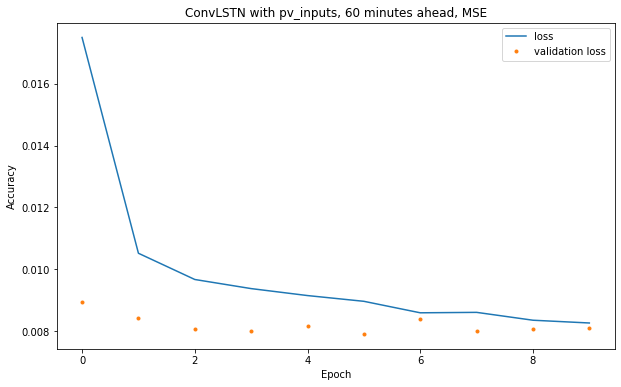

In [ ]:
convlstm_1hr = convlstm_model(12, x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test)

Epoch 1/10
364/364 [==============================] - 37s 101ms/step - loss: 0.9514 - val_loss: 0.0102 - lr: 0.0010
Epoch 2/10
364/364 [==============================] - 37s 101ms/step - loss: 0.0177 - val_loss: 0.0078 - lr: 0.0010
Epoch 3/10
364/364 [==============================] - 37s 101ms/step - loss: 0.0158 - val_loss: 0.0084 - lr: 0.0010
Epoch 4/10
364/364 [==============================] - 37s 101ms/step - loss: 0.0135 - val_loss: 0.0075 - lr: 0.0010
Epoch 5/10
364/364 [==============================] - 37s 101ms/step - loss: 0.0123 - val_loss: 0.0076 - lr: 0.0010
Epoch 6/10
364/364 [==============================] - 36s 100ms/step - loss: 0.0117 - val_loss: 0.0071 - lr: 0.0010
Epoch 7/10
364/364 [==============================] - 37s 100ms/step - loss: 0.0113 - val_loss: 0.0076 - lr: 0.0010
Epoch 8/10
364/364 [==============================] - 36s 100ms/step - loss: 0.0105 - val_loss: 0.0083 - lr: 0.0010
Epoch 9/10
364/364 [==============================] - 36s 100ms/step - l

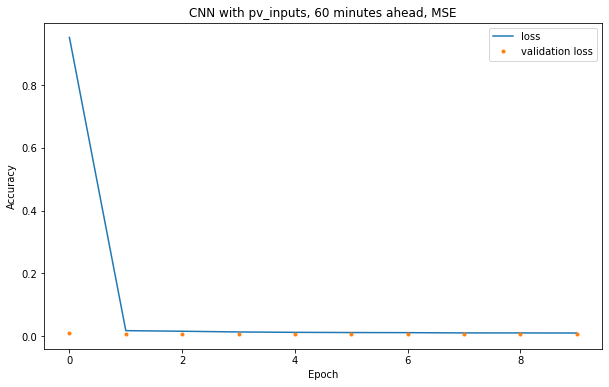

In [ ]:
cnn_1hr = cnn_model(12, x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test)

# Comparison for 2hr forward, 1hr input, padded, no mask




In [ ]:
x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test = dataloader(24, 12, train_sat_images, train_sat_times, test_sat_images, test_sat_times, train_pv, test_pv)

Satellite and PV blocks generated.

Sat images array: (1265, 12, 64, 64) , PV targets array: (1265, 24)
Timestamps, sat (1265, 12)  , pv (1265, 24)
PV inputs (1265, 12)
Altitudes for PV timestamps (1265, 24)
Satellite and PV blocks generated.

Sat images array: (256, 12, 64, 64) , PV targets array: (256, 24)
Timestamps, sat (256, 12)  , pv (256, 24)
PV inputs (256, 12)
Altitudes for PV timestamps (256, 24)


In [ ]:
x_train_sat_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_sat, 24, dtype='float64', padding='post')
x_test_sat_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_sat, 24, dtype='float64', padding='post')

x_train_pv_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_pv_inputs, 24, dtype='float64', padding='post')
x_test_pv_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_pv_inputs, 24, dtype='float64', padding='post')

print(x_train_sat_padded.shape, x_train_pv_inputs_padded.shape, y_train.shape)

(1265, 24, 64, 64, 1) (1265, 24, 1) (1265, 24)


Epoch 1/10
228/228 [==============================] - 62s 234ms/step - loss: 0.0393 - val_loss: 0.0177 - lr: 0.0010
Epoch 2/10
228/228 [==============================] - 52s 229ms/step - loss: 0.0212 - val_loss: 0.0163 - lr: 0.0010
Epoch 3/10
228/228 [==============================] - 52s 229ms/step - loss: 0.0188 - val_loss: 0.0184 - lr: 0.0010
Epoch 4/10
228/228 [==============================] - 52s 229ms/step - loss: 0.0192 - val_loss: 0.0228 - lr: 0.0010
Epoch 5/10
228/228 [==============================] - 52s 229ms/step - loss: 0.0171 - val_loss: 0.0147 - lr: 0.0010
Epoch 6/10
228/228 [==============================] - 52s 230ms/step - loss: 0.0164 - val_loss: 0.0165 - lr: 0.0010
Epoch 7/10
228/228 [==============================] - 52s 228ms/step - loss: 0.0161 - val_loss: 0.0174 - lr: 0.0010
Epoch 8/10
228/228 [==============================] - 52s 229ms/step - loss: 0.0160 - val_loss: 0.0164 - lr: 0.0010
Epoch 9/10
228/228 [==============================] - 52s 229ms/step - l

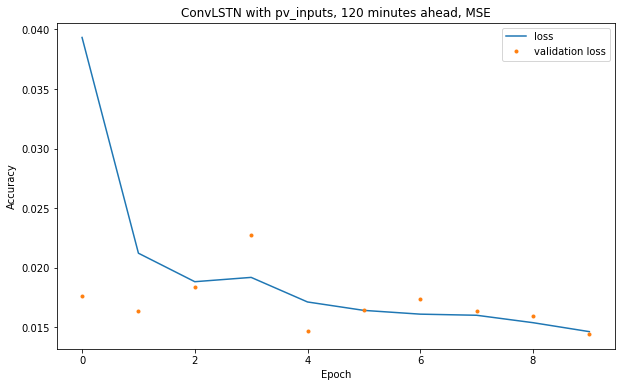

In [ ]:
convlstm_2hr = convlstm_model(24, x_train_sat_padded, x_train_pv_inputs_padded, y_train, x_test_sat_padded, x_test_pv_inputs_padded, y_test)

Epoch 1/10
228/228 [==============================] - 21s 86ms/step - loss: 0.2002 - val_loss: 0.0184 - lr: 0.0010
Epoch 2/10
228/228 [==============================] - 19s 85ms/step - loss: 0.0261 - val_loss: 0.0155 - lr: 0.0010
Epoch 3/10
228/228 [==============================] - 19s 85ms/step - loss: 0.0200 - val_loss: 0.0147 - lr: 0.0010
Epoch 4/10
228/228 [==============================] - 19s 84ms/step - loss: 0.0187 - val_loss: 0.0143 - lr: 0.0010
Epoch 5/10
228/228 [==============================] - 19s 84ms/step - loss: 0.0178 - val_loss: 0.0134 - lr: 0.0010
Epoch 6/10
228/228 [==============================] - 19s 84ms/step - loss: 0.0168 - val_loss: 0.0137 - lr: 0.0010
Epoch 7/10
228/228 [==============================] - 19s 84ms/step - loss: 0.0163 - val_loss: 0.0132 - lr: 0.0010
Epoch 8/10
228/228 [==============================] - 19s 84ms/step - loss: 0.0158 - val_loss: 0.0131 - lr: 0.0010
Epoch 9/10
228/228 [==============================] - 19s 84ms/step - loss: 0.01

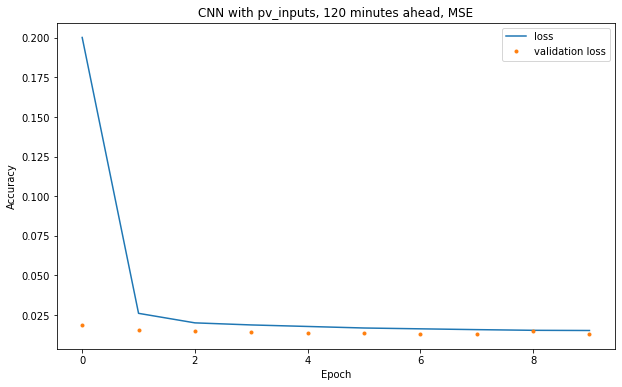

In [ ]:
# This one doesn't need padding, just takes in the dimensions of x and y
cnn_2hr = cnn_model(24, x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test)

# Comparison for 3hr forward, 1hr input, padded, no mask




In [ ]:
x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test = dataloader(36, 12, train_sat_images, train_sat_times, test_sat_images, test_sat_times, train_pv, test_pv)

x_train_sat_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_sat, 36, dtype='float64', padding='post')
x_test_sat_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_sat, 36, dtype='float64', padding='post')

x_train_pv_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_pv_inputs, 36, dtype='float64', padding='post')
x_test_pv_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_pv_inputs, 36, dtype='float64', padding='post')

print(x_train_sat_padded.shape, x_train_pv_inputs_padded.shape, y_train.shape)

Satellite and PV blocks generated.

Sat images array: (897, 12, 64, 64) , PV targets array: (897, 36)
Timestamps, sat (897, 12)  , pv (897, 36)
PV inputs (897, 12)
Altitudes for PV timestamps (897, 36)
Satellite and PV blocks generated.

Sat images array: (188, 12, 64, 64) , PV targets array: (188, 36)
Timestamps, sat (188, 12)  , pv (188, 36)
PV inputs (188, 12)
Altitudes for PV timestamps (188, 36)
(897, 36, 64, 64, 1) (897, 36, 1) (897, 36)


Epoch 1/10
162/162 [==============================] - 65s 348ms/step - loss: 0.0428 - val_loss: 0.0193 - lr: 0.0010
Epoch 2/10
162/162 [==============================] - 55s 342ms/step - loss: 0.0273 - val_loss: 0.0301 - lr: 0.0010
Epoch 3/10
162/162 [==============================] - 55s 339ms/step - loss: 0.0263 - val_loss: 0.0181 - lr: 0.0010
Epoch 4/10
162/162 [==============================] - 55s 339ms/step - loss: 0.0244 - val_loss: 0.0182 - lr: 0.0010
Epoch 5/10
162/162 [==============================] - 55s 337ms/step - loss: 0.0233 - val_loss: 0.0208 - lr: 0.0010
Epoch 6/10
162/162 [==============================] - 55s 338ms/step - loss: 0.0234 - val_loss: 0.0221 - lr: 0.0010
Epoch 7/10
162/162 [==============================] - 55s 342ms/step - loss: 0.0248 - val_loss: 0.0181 - lr: 0.0010
Epoch 8/10
162/162 [==============================] - 55s 341ms/step - loss: 0.0223 - val_loss: 0.0239 - lr: 0.0010
Epoch 9/10
162/162 [==============================] - 55s 339ms/step - l

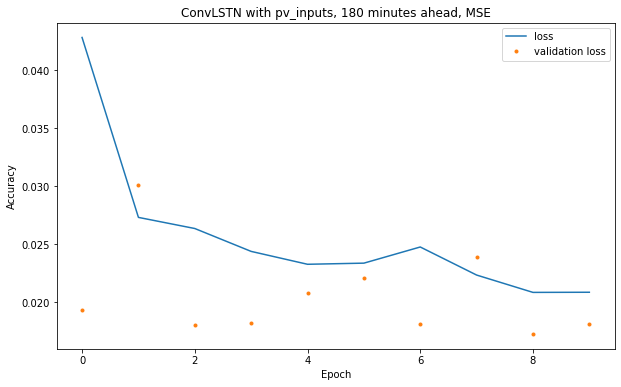

In [ ]:
convlstm_3hr = convlstm_model(36, x_train_sat_padded, x_train_pv_inputs_padded, y_train, x_test_sat_padded, x_test_pv_inputs_padded, y_test)

Epoch 1/10
162/162 [==============================] - 15s 86ms/step - loss: 0.3519 - val_loss: 0.0208 - lr: 0.0010
Epoch 2/10
162/162 [==============================] - 14s 84ms/step - loss: 0.0320 - val_loss: 0.0182 - lr: 0.0010
Epoch 3/10
162/162 [==============================] - 14s 84ms/step - loss: 0.0272 - val_loss: 0.0155 - lr: 0.0010
Epoch 4/10
162/162 [==============================] - 14s 85ms/step - loss: 0.0255 - val_loss: 0.0150 - lr: 0.0010
Epoch 5/10
162/162 [==============================] - 14s 84ms/step - loss: 0.0223 - val_loss: 0.0186 - lr: 0.0010
Epoch 6/10
162/162 [==============================] - 14s 84ms/step - loss: 0.0222 - val_loss: 0.0148 - lr: 0.0010
Epoch 7/10
162/162 [==============================] - 14s 84ms/step - loss: 0.0213 - val_loss: 0.0143 - lr: 0.0010
Epoch 8/10
162/162 [==============================] - 14s 84ms/step - loss: 0.0207 - val_loss: 0.0144 - lr: 0.0010
Epoch 9/10
162/162 [==============================] - 14s 84ms/step - loss: 0.02

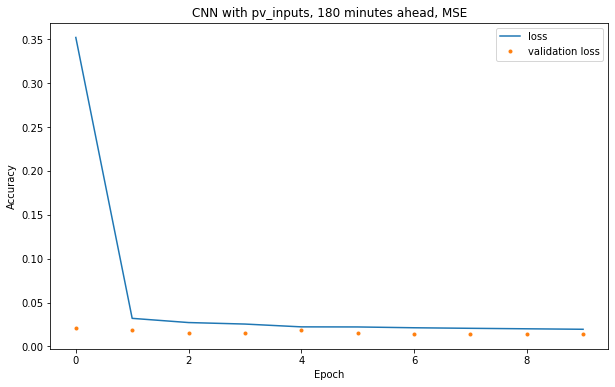

In [ ]:
cnn_3hr = cnn_model(36, x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test)

# Comparison for 4hr forward, 1hr input, no mask

In [ ]:
x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test = dataloader(48, 12, train_sat_images, train_sat_times, test_sat_images, test_sat_times, train_pv, test_pv)

x_train_sat_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_sat, 48, dtype='float64', padding='post')
x_test_sat_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_sat, 48, dtype='float64', padding='post')

x_train_pv_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_pv_inputs, 48, dtype='float64', padding='post')
x_test_pv_inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_pv_inputs, 48, dtype='float64', padding='post')

print(x_train_sat_padded.shape, x_train_pv_inputs_padded.shape, y_train.shape)

Satellite and PV blocks generated.

Sat images array: (659, 12, 64, 64) , PV targets array: (659, 48)
Timestamps, sat (659, 12)  , pv (659, 48)
PV inputs (659, 12)
Altitudes for PV timestamps (659, 48)
Satellite and PV blocks generated.

Sat images array: (136, 12, 64, 64) , PV targets array: (136, 48)
Timestamps, sat (136, 12)  , pv (136, 48)
PV inputs (136, 12)
Altitudes for PV timestamps (136, 48)
(659, 48, 64, 64, 1) (659, 48, 1) (659, 48)


Epoch 1/10
119/119 [==============================] - 61s 438ms/step - loss: 15.9832 - val_loss: 0.0496 - lr: 0.0010
Epoch 2/10
119/119 [==============================] - 52s 435ms/step - loss: 0.0523 - val_loss: 0.0337 - lr: 0.0010
Epoch 3/10
119/119 [==============================] - 51s 432ms/step - loss: 0.0406 - val_loss: 0.0258 - lr: 0.0010
Epoch 4/10
119/119 [==============================] - 51s 432ms/step - loss: 0.0371 - val_loss: 0.0241 - lr: 0.0010
Epoch 5/10
119/119 [==============================] - 52s 436ms/step - loss: 0.0365 - val_loss: 0.0260 - lr: 0.0010
Epoch 6/10
119/119 [==============================] - 52s 433ms/step - loss: 0.0359 - val_loss: 0.0265 - lr: 0.0010
Epoch 7/10
119/119 [==============================] - 52s 433ms/step - loss: 0.0318 - val_loss: 0.0253 - lr: 0.0010
Epoch 8/10
119/119 [==============================] - 52s 435ms/step - loss: 0.0427 - val_loss: 0.0257 - lr: 0.0010
Epoch 9/10
119/119 [==============================] - 51s 432ms/step - 

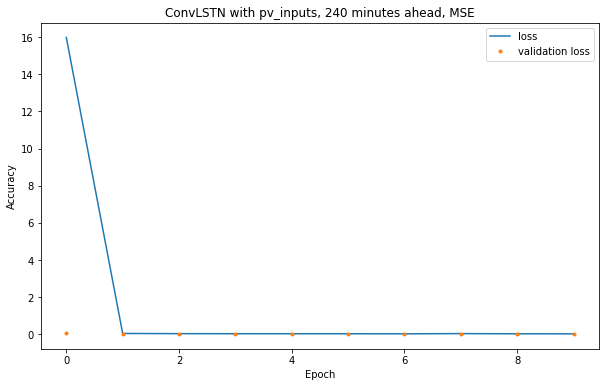

In [ ]:
convlstm_4hr = convlstm_model(48, x_train_sat_padded, x_train_pv_inputs_padded, y_train, x_test_sat_padded, x_test_pv_inputs_padded, y_test)

Epoch 1/10
119/119 [==============================] - 11s 83ms/step - loss: 0.1433 - val_loss: 0.0284 - lr: 0.0010
Epoch 2/10
119/119 [==============================] - 10s 82ms/step - loss: 0.0348 - val_loss: 0.0201 - lr: 0.0010
Epoch 3/10
119/119 [==============================] - 10s 82ms/step - loss: 0.0287 - val_loss: 0.0198 - lr: 0.0010
Epoch 4/10
119/119 [==============================] - 10s 83ms/step - loss: 0.0261 - val_loss: 0.0170 - lr: 0.0010
Epoch 5/10
119/119 [==============================] - 10s 83ms/step - loss: 0.0228 - val_loss: 0.0159 - lr: 0.0010
Epoch 6/10
119/119 [==============================] - 10s 83ms/step - loss: 0.0226 - val_loss: 0.0161 - lr: 0.0010
Epoch 7/10
119/119 [==============================] - 10s 83ms/step - loss: 0.0211 - val_loss: 0.0145 - lr: 0.0010
Epoch 8/10
119/119 [==============================] - 10s 83ms/step - loss: 0.0213 - val_loss: 0.0156 - lr: 0.0010
Epoch 9/10
119/119 [==============================] - 10s 83ms/step - loss: 0.01

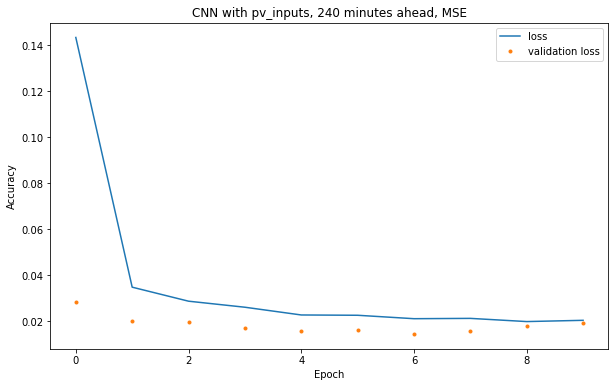

In [ ]:
cnn_4hr = cnn_model(48, x_train_sat, x_train_pv_inputs, y_train, x_test_sat, x_test_pv_inputs, y_test)

# Evaluation

In [ ]:
cnn_results = [cnn_1hr['loss'], cnn_2hr['loss'], cnn_3hr['loss'], cnn_4hr['loss']]
convlstm_results = [convlstm_1hr['loss'], convlstm_2hr['loss'], convlstm_3hr['loss'], convlstm_4hr['loss']]

print(cnn_results)
print(convlstm_results)

NameError: ignored

In [ ]:
np.arange(4) +1

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(4) +1 , cnn_results, label='CNN')
plt.plot(np.arange(4) +1 , convlstm_results, label='convlstm')
plt.title('Comparison of test error, 1hr input data')
plt.legend();